In [1]:
import pandas as pd
import datetime
import numpy as np
import tensorflow as tf

# グラフ描画
from matplotlib import pylab as plt

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
from oanda_utils import load_assign_dtype

In [4]:
df_m = load_assign_dtype("data/usd_jpy_m1.csv")
df_h = load_assign_dtype("data/usd_jpy_h1.csv")
df_d = load_assign_dtype("data/usd_jpy_d.csv")

In [57]:
x_list = []
y_list = []
cnt = 0

for target_time in df_m['time'][60:]:

    to_minute = target_time
    to_hour = target_time - datetime.timedelta(minutes = target_time.minute)
    to_date = target_time -  datetime.timedelta(days=1, minutes = target_time.minute, hours = target_time.hour)

    m_cond = (df_m['time']  < to_minute) 
    h_cond =  (df_h['time']  < to_hour) 
    d_cond = (df_d['time'] < to_date)

    df_m_target = df_m[m_cond][-60:]
    df_h_target = df_h[h_cond][-24:]
    df_d_target = df_d[d_cond][-20:]

    df_target = pd.concat([df_d_target, df_h_target, df_m_target])
    if df_target.shape != (104, 7):
        cnt += 1
        print(target_time, df_target.shape, cnt)
        continue
    x_list.append(df_target[['O', 'H', 'L', 'C']].values[np.newaxis, :, :])
    y_list.append(df_m[df_m['time'] == target_time]['C'].values[np.newaxis, :])

In [61]:
X = np.vstack(x_list)
y = np.vstack(y_list)

<AxesSubplot:>

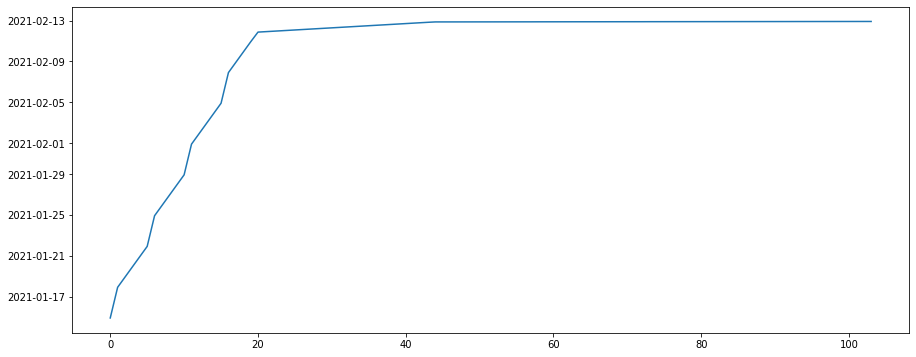

In [70]:
df_target.reset_index()['time'].plot()

<AxesSubplot:xlabel='time'>

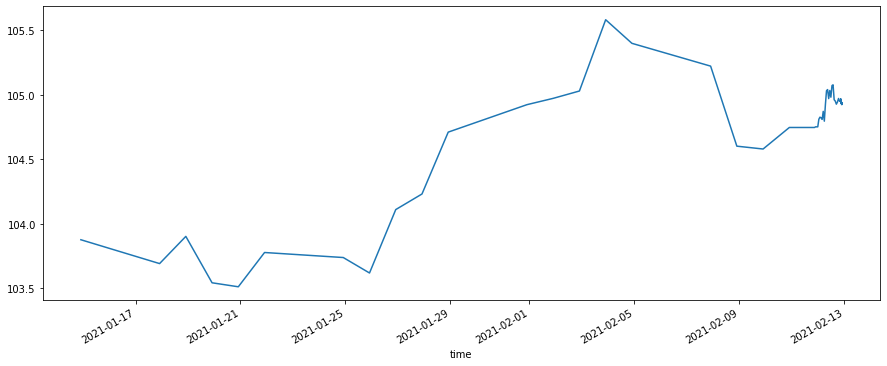

In [65]:
df_target.set_index('time')['C'].plot()

<AxesSubplot:xlabel='time'>

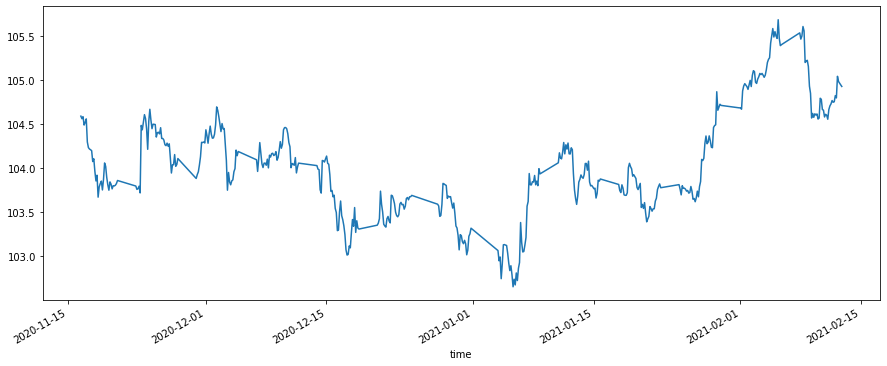

In [10]:
df['C'].plot()

<AxesSubplot:xlabel='time'>

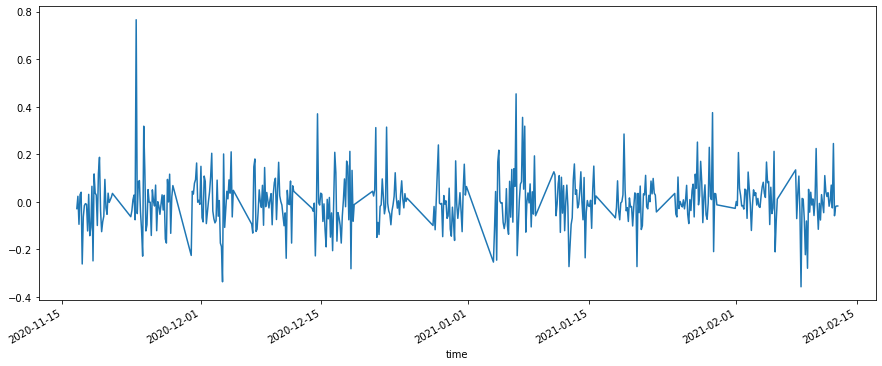

In [11]:
df_diff['C'].plot()